# Kaggle Tutorial with RandomForest

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

df_train_original = pd.read_csv('./data/train.csv')
df_test_original = pd.read_csv('./data/test.csv')

print('The number of missing train data:\n', df_train_original.isnull().sum())
print('\nThe number of missing test data:\n', df_test_original.isnull().sum())

The number of missing train data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The number of missing test data:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Preprocess

In [3]:
df_train = df_train_original
df_test = df_test_original

# 欠損値補完
df_train['Fare'].fillna(df_train['Fare'].median(), inplace=True)
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_train['Embarked'].fillna('S', inplace=True)

df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True)
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

# カテゴリ変数の変換
# Object -> 数値
df_train['Sex'] =  df_train['Sex'].map({'male':0, 'female':1})
df_test['Sex'] = df_test['Sex'].map({'male':0, 'female':1})

# one-hot
df_train = pd.get_dummies(df_train, columns=['Embarked'])
df_train = pd.get_dummies(df_train, columns=['Pclass'])

df_test = pd.get_dummies(df_test, columns=['Embarked'])
df_test = pd.get_dummies(df_test, columns=['Pclass'])

# 予測に使用しない列の削除
df_train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
df_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)


df_train

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,0,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1,1,0,0
4,0,0,35.0,0,0,8.0500,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,13.0000,0,0,1,0,1,0
887,1,1,19.0,0,0,30.0000,0,0,1,1,0,0
888,0,1,28.0,1,2,23.4500,0,0,1,0,0,1
889,1,0,26.0,0,0,30.0000,1,0,0,1,0,0


## Divide data

In [4]:
from sklearn.model_selection import train_test_split

train_x = df_train.drop(columns=['Survived'])
train_y = df_train['Survived']

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=100)

## Define model

In [5]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

## Train model

In [6]:
clf.fit(train_x, train_y)

RandomForestClassifier()

## Valify model

In [7]:
from sklearn.metrics import accuracy_score

pred = clf.predict(val_x)
print('train accuracy:', clf.score(train_x, train_y))
print('accuracy:', accuracy_score(pred, val_y))

train accuracy: 0.9845505617977528
accuracy: 0.8212290502793296


## Compute F1 Score

precision: 0.8115942028985508
recall: 0.7466666666666667
f1_score: 0.7777777777777779


<AxesSubplot:>

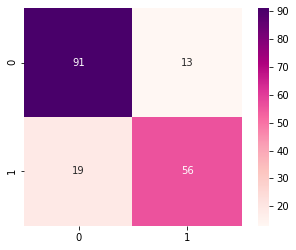

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(val_y, pred)
tn, fp, fn, tp = cm.flatten()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)
print('precision:', precision)
print('recall:', recall)
print('f1_score:', f1_score)

sns.heatmap(cm, square=True, annot=True, fmt='d', cmap='RdPu')

## Compute important feature

In [9]:
importance = pd.DataFrame({ '変数' :train_x.columns, '重要度' :clf.feature_importances_})
importance

,変数,重要度
0,Sex,0.256863
1,Age,0.261700
2,SibSp,0.043456
3,Parch,0.037024
4,Fare,0.265345
5,Embarked_C,0.012874
6,Embarked_Q,0.008129
7,Embarked_S,0.013847
8,Pclass_1,0.028701
9,Pclass_2,0.015992


## Compute ROC Curve and AUC

AUC: 0.8108333333333333


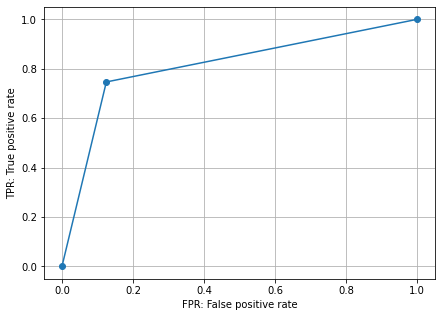

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(val_y, pred, pos_label=1)
print('AUC:', auc(fpr, tpr))
plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

## Visualize RandomForest tree with graphviz

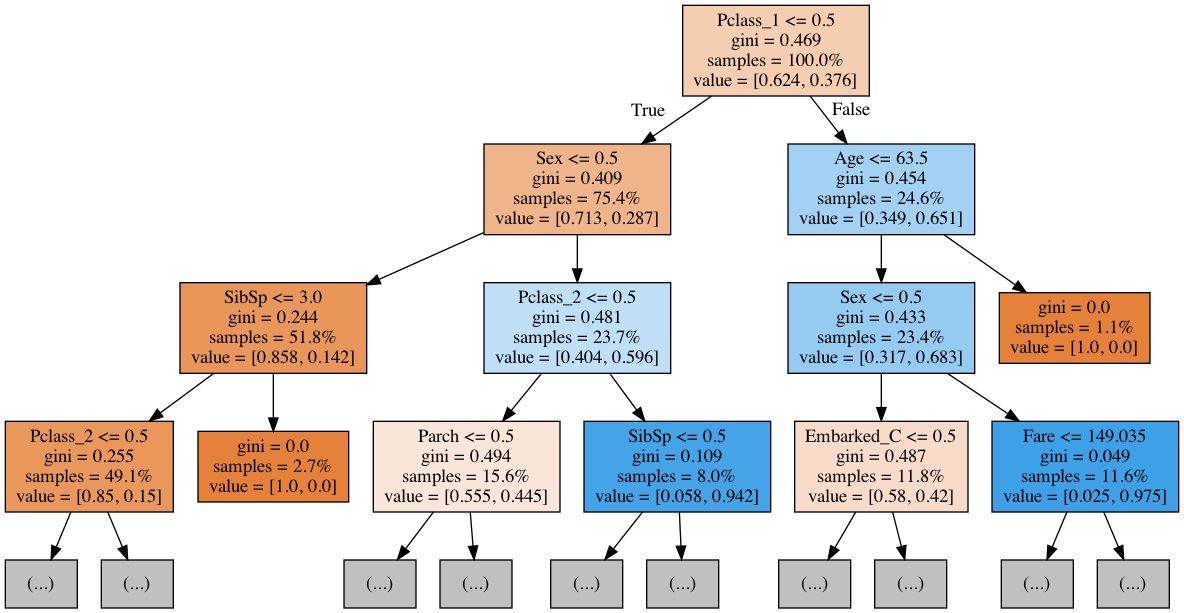

In [11]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from graphviz import Digraph


dot_data = export_graphviz(clf.estimators_[0], out_file=None, feature_names=train_x.columns, filled=True, proportion=True, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Export results


In [12]:
pred = clf.predict(df_test)
df_pred = pd.DataFrame({'PassengerId':df_test_original['PassengerId'], 'Survived':pred})
df_pred.to_csv('titanic_result.csv',index=False)
df_pred

,PassengerId,Survivied
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
